# Traffic Flow Regression - V3
## - <i>Feature Selection and Model Comparison</i>
 - this notebook builds upon traffic_flow_regression_V2 but paying closer attention to the features used and testing out different models
 - see EDA.ipynb for a deeper understanding of the data

# Imports

In [39]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, validation_curve
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from mlxtend.evaluate import bias_variance_decomp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.svm import SVR


# Read Dataset
Using dataset created in notebook v2 that has additional feature engineering and integrates multiple data sources

In [41]:
overall_df = pd.read_csv('ml_datasets/v2_dataset.csv')
overall_df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2


## Choose Site
We will start off by just focusing on one site. In our EDA we saw that Site N03121A is isolated so we will choose this one as it is less likely for multicollinearity to occur (where features depend on each other)

In [42]:
df = overall_df[overall_df['site']=='N03121A']
df

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
700,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-04,-6.424314,53.357202,109,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
701,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-14,-6.424314,53.357202,97,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
702,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-21,-6.424314,53.357202,90,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
703,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-28,-6.424314,53.357202,96,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
704,00:00,2024-10-12 00:00:00,N03121A,FR,2022-02-18,-6.424314,53.357202,149,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41394,23:30,2024-10-12 23:30:00,N03121A,WE,2022-05-25,-6.424314,53.357202,67,5,23,...,0,0.0,0,10.5,0,9.2,7.9,10.7,84,1016.5
41395,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-04,-6.424314,53.357202,104,6,23,...,0,0.0,0,12.4,0,10.7,9.0,11.5,80,1019.8
41396,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-15,-6.424314,53.357202,68,6,23,...,0,0.0,0,11.3,0,10.9,10.5,12.7,94,1020.9
41397,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-22,-6.424314,53.357202,74,6,23,...,0,0.0,0,16.0,0,14.9,14.1,16.0,88,1012.7


# Machine Learning Workflow
- In this notebook I want to establish a framework for arriving at the best possible model. 
- Lets start by selecting our features
## 1. Feature Selection

In [43]:
cat_features = ['day', 'time_(hour)']
num_features = [#'previous_flow_N01111A','previous_flow_N01131A','previous_flow_N01151A','previous_flow_N02111A','previous_flow_N02131A','previous_flow_N03121A','overall_previous_flow',
               #  'distance_N01111A',
    #    'duration_N01111A', 'distance_N01131A', 'duration_N01131A',
    #    'distance_N01151A', 'duration_N01151A', 'distance_N02111A',
    #    'duration_N02111A', 'distance_N02131A', 'duration_N02131A',
    #    'distance_N03121A', 'duration_N03121A',
       'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum',
       'msl']


### Learning!
- I learned that having these constant values of distance and duration actually provide no use to the model so they will be removed

### Numerical Features - Correlation Matrix

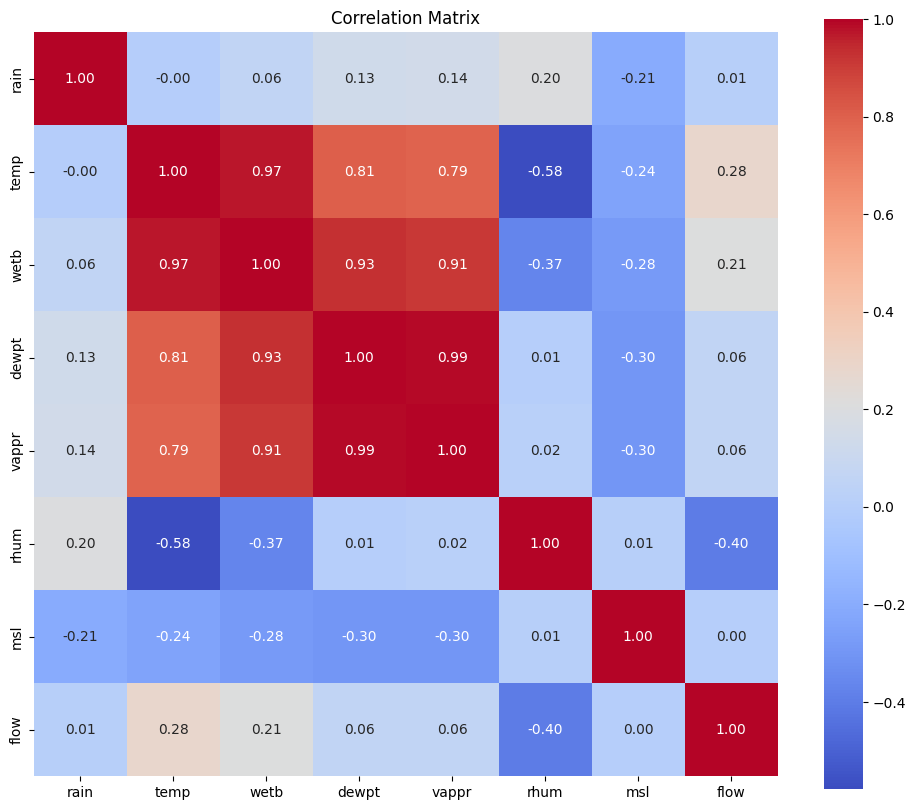

In [44]:
corr_features = num_features+ ['flow']
correlation_matrix = df[corr_features].corr()

# Set the size of the plot
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()



Observations
- The previous flow at other sites are highly correlated to each other except for site N01131A. 
    - Let's keep the previous flow at N01131A and use overall previous flow but leave out the other sites
- Temperature is highly correlated with wet bulb and dew point temperature.
    - For now let's just use the one temperature feature
Let's now define these new features

In [70]:
num_features = ['previous_flow_N01131A','overall_previous_flow','rain', 'temp', 'vappr', 'rhum','msl']


Lets show the new correlation matrix

In [77]:
overall_df[(overall_df['site']=='N01131A') & overall_df['flow']==0]

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41394,23:30,2024-10-12 23:30:00,N03121A,WE,2022-05-25,-6.424314,53.357202,67,5,23,...,0,0.0,0,10.5,0,9.2,7.9,10.7,84,1016.5
41395,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-04,-6.424314,53.357202,104,6,23,...,0,0.0,0,12.4,0,10.7,9.0,11.5,80,1019.8
41396,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-15,-6.424314,53.357202,68,6,23,...,0,0.0,0,11.3,0,10.9,10.5,12.7,94,1020.9
41397,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-22,-6.424314,53.357202,74,6,23,...,0,0.0,0,16.0,0,14.9,14.1,16.0,88,1012.7


In [92]:
overall_df[(overall_df['site']=='N01131A') & (overall_df['flow']==0)]

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
145,00:00,2024-10-12 00:00:00,N01131A,FR,2022-02-18,-6.352204,53.301229,0,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
146,00:00,2024-10-12 00:00:00,N01131A,FR,2022-02-25,-6.352204,53.301229,0,2,0,...,0,0.0,0,3.2,0,2.3,0.7,6.4,83,1017.9
147,00:00,2024-10-12 00:00:00,N01131A,FR,2022-03-06,-6.352204,53.301229,0,3,0,...,0,0.0,0,-1.6,0,-1.9,-2.5,5.1,93,1034.0
148,00:00,2024-10-12 00:00:00,N01131A,FR,2022-03-18,-6.352204,53.301229,0,3,0,...,0,0.0,0,1.9,0,1.6,1.0,6.6,94,1037.2
149,00:00,2024-10-12 00:00:00,N01131A,FR,2022-03-25,-6.352204,53.301229,0,3,0,...,0,0.0,0,7.1,0,6.3,5.4,9.0,89,1031.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40814,23:30,2024-10-12 23:30:00,N01131A,WE,2022-05-25,-6.352204,53.301229,0,5,23,...,0,0.0,0,10.5,0,9.2,7.9,10.7,84,1016.5
40815,23:30,2024-10-12 23:30:00,N01131A,WE,2022-06-04,-6.352204,53.301229,0,6,23,...,0,0.0,0,12.4,0,10.7,9.0,11.5,80,1019.8
40816,23:30,2024-10-12 23:30:00,N01131A,WE,2022-06-15,-6.352204,53.301229,0,6,23,...,0,0.0,0,11.3,0,10.9,10.5,12.7,94,1020.9
40817,23:30,2024-10-12 23:30:00,N01131A,WE,2022-06-22,-6.352204,53.301229,0,6,23,...,0,0.0,0,16.0,0,14.9,14.1,16.0,88,1012.7


In [91]:
df[df['previous_flow_N01131A']==0]['date'].value_counts()

date
2022-01-04    49
2022-03-24    49
2022-01-25    49
2022-01-18    49
2022-01-03    49
              ..
2022-02-01     2
2022-05-01     2
2022-06-01     2
2022-03-01     2
2022-04-01     2
Name: count, Length: 140, dtype: int64

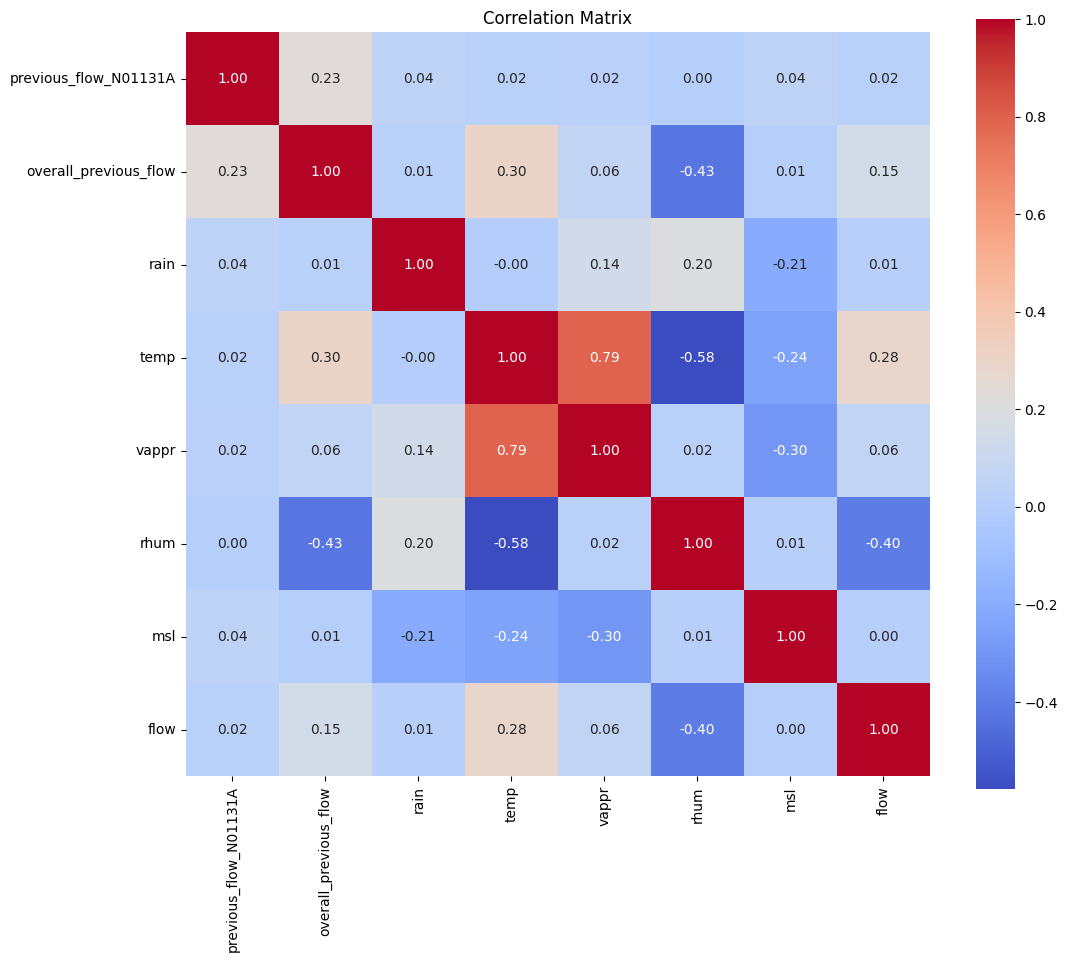

In [71]:
corr_features = num_features+ ['flow']
correlation_matrix = df[corr_features].corr()

# Set the size of the plot
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()



We could do something similar for categorical features via a chi-square analysis, but we only have two categorical features. We can confirm these variables are staistically significant however via an ANOVA test

In [47]:
groups_time = [group['flow'].values for name, group in df.groupby('time_(hour)')]
groups_day_of_week = [group['flow'].values for name, group in df.groupby('day')]

results = {'day_of_week':{'f_statistic': None, 'p_value':None},
           'hour':{'f_statistic': None, 'p_value':None}}
# Conducting the ANOVA test
f_statistic, p_value = stats.f_oneway(*groups_day_of_week)
results['day_of_week']['f_statistic'] = f_statistic
results['day_of_week']['p_value'] = p_value

f_statistic, p_value = stats.f_oneway(*groups_time)
results['hour']['f_statistic'] = f_statistic
results['hour']['p_value'] = p_value
# Output the results
print(f"Day of week: \nF-statistic: {results['day_of_week']['f_statistic']}, p-value: {results['day_of_week']['p_value']}")
# Output the results
print(f"Hour: \nF-statistic: {results['hour']['f_statistic']}, p-value: {results['hour']['p_value']}")

Day of week: 
F-statistic: 15.226896896652525, p-value: 2.062686268628703e-17
Hour: 
F-statistic: 287.52773106579957, p-value: 0.0


The p-values are both extremely low (<<0.05) meaning they are statistically significant

## 2. Model Selection
Next we will conduct an in-depth investigation into the choice of machine learning algorithm to use for this problem

### 2.1 First train test split

In [48]:
X = df[num_features+cat_features]
y = df['flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### 2.1.1 Train Validation Split

In [49]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

### 2.2 Linear Model
#### 2.2.1 Linear Regression
In notebook V1 we tried out using a linear regression model. We saw that the results weren't great but let's investigate this more rigorously and explain clearly why it doesn't work
- we won't concern ourselves with the data preprocessing here as it is standard enough (one hot encoding and numerical feature scaling)

In [50]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Set the depth
])

Lets now evaluate the performance of linear regression using 5-fold cross validation on the train and test cets

In [51]:
def cross_validate_train_and_test(pipeline, cv, X, y):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    train_maes = []
    test_maes = []

    train_r2s = []
    test_r2s = []

    for train_index, val_index in kf.split(X):
        X_cv_train, X_cv_val = X.iloc[train_index], X.iloc[val_index]  # Use iloc for DataFrame
        y_cv_train, y_cv_val = y.iloc[train_index], y.iloc[val_index]  # Consistent naming

        # Fit the model
        pipeline.fit(X_cv_train, y_cv_train)

        # Calculate train and test errors
        predictions_train = pipeline.predict(X_cv_train)
        predictions_val = pipeline.predict(X_cv_val)
        
        mae_train = mean_absolute_error(y_cv_train, predictions_train)
        mae_val = mean_absolute_error(y_cv_val, predictions_val)

        r2_train = r2_score(y_cv_train, predictions_train)
        r2_test = r2_score(y_cv_val, predictions_val)


        train_maes.append(mae_train)
        test_maes.append(mae_val)

        train_r2s.append(r2_train)
        test_r2s.append(r2_test)

    mean_mae_test = np.mean(test_maes)
    mean_mae_train = np.mean(train_maes)
    mean_r2_test = np.mean(test_r2s)
    mean_r2_train = np.mean(train_r2s)

    print('Mean MAE Test:', mean_mae_test)
    print('Mean MAE Train:', mean_mae_train)
    print('Mean R2 Test:', mean_r2_test)
    print('Mean R2 Train:', mean_r2_train)

    return mean_mae_test, mean_mae_train, mean_r2_test, mean_r2_train

In [52]:
cross_validate_train_and_test(pipeline_lr, 5, X, y)

Mean MAE Test: 257.5296888365996
Mean MAE Train: 255.9365143650376
Mean R2 Test: 0.48884305920157367
Mean R2 Train: 0.49683024854354346


(np.float64(257.5296888365996),
 np.float64(255.9365143650376),
 np.float64(0.48884305920157367),
 np.float64(0.49683024854354346))

#### Observations
- Cool! Compared to our analysis in notebook v1 we see a much better model being fit (MAE was 521 in that case). However the error is still too high for my liking
- The key thing to notice here is the very close values between the train and test errors. This indicates the model is **underfitting** and has **high bias**
    - lets verify this via a bias-variance decomposition of the squared error

#### Bias-Variance Decompisition

In [53]:
def bias_variance_pipeline(pipeline, X, y):

        pipeline.fit(X_train, y_train)
        # Separate the preprocessing step from the pipeline
        preprocessor = pipeline.named_steps['preprocessor']

        # Transform the training and test data using the preprocessing step
        X_train_processed = preprocessor.transform(X_train)
        X_test_processed = preprocessor.transform(X_test)

        # Now pass the processed NumPy arrays to bias_variance_decomp
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
                pipeline.named_steps['regressor'],  # Use only the regressor step here
                X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
                X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)
                loss='mse',
                random_seed=123)

        print(f"Average Expected Loss: {avg_expected_loss}")
        print(f"Average Bias: {avg_bias}")
        print(f"Average Variance: {avg_var}")


In [54]:
bias_variance_pipeline(pipeline_lr, X_train, y_train)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12714/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12714/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 99658.1945339036
Average Bias: 98942.22018613185
Average Variance: 715.9743477717534


#### Observations
- as predicted, the majority of the expected loss is coming from the bias term as opposed to the variance 
- we should therefore look at a more complex model
    - One we we could increase the complexity of the model is via polynomial features so let's try this

##### 2.2.1.1 Polynomial Regression

In [55]:
def create_poly_pipeline(degree):
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree))  # Standardize numerical features
                ]), num_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
            ]
            )

    # Create the pipeline
    pipeline_lr_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())  # Set the depth
    ])
    return pipeline_lr_poly

Let's experiment with a few values of "degree" that controls the exponent of the polynomial

In [56]:
mae_test = []
mae_train = []
degrees = [2]#, 3, 4, 5]
for degree in degrees:
    print('Degree Polynomial: ', degree)
    mean_mae_test, mean_mae_train, _, _ = cross_validate_train_and_test(create_poly_pipeline(degree), 5, X, y)
    mae_test.append(mean_mae_test)
    mae_train.append(mean_mae_train)
    print('')


Degree Polynomial:  2
Mean MAE Test: 258.31458987848157
Mean MAE Train: 255.24746856391954
Mean R2 Test: 0.4854813384464432
Mean R2 Train: 0.49955372103258994



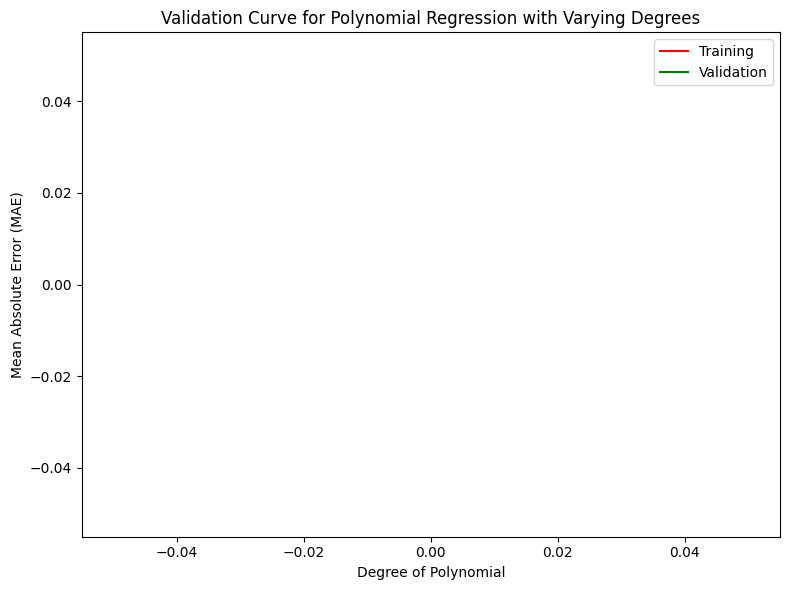

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(degrees[0:-1], mae_test[0:-1], label="Training", color="r")
plt.plot(degrees[0:-1], mae_train[0:-1], label="Validation", color="g")
plt.title("Validation Curve for Polynomial Regression with Varying Degrees")
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Absolute Error (MAE)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### Observations
- we see a polynomial fit with degree = 3 gives the best generalisation performance here, before the model starts to severely overfit
- we could investigate variants of linear regression with regularisation such as Ridge and Lasso regression on these higher degree polynomials to see if we can stop overfitting while retaining the higher perofrmance they are showing on the test set. However the benefits are not hugely better and regularisation will come at the cost of decreases training error. Also computational complexity becomes a concern at these higher degree polynomials

### 2.2.1 Support Vector Machine

In [58]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel="linear")) 
])

In [59]:
cross_validate_train_and_test(pipeline_svm, 5, X, y)

Mean MAE Test: 267.5457499487312
Mean MAE Train: 266.787929287285
Mean R2 Test: 0.16195956437700165
Mean R2 Train: 0.16440496723844233


(np.float64(267.5457499487312),
 np.float64(266.787929287285),
 np.float64(0.16195956437700165),
 np.float64(0.16440496723844233))

Observations
- Output is quite poor compared to linear regression so this model doesn't seem suited either

## 2.3 Tree Models
We will next look at tree models a little more in depth than we have before

### 2.3.1 Decision Tree
(No preprocessing steps needs for decision tree)

In [60]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())  # Set the depth
])

In [61]:
cross_validate_train_and_test(pipeline_dt, 5, X, y)

Mean MAE Test: 246.77794677804226
Mean MAE Train: 239.70081146752017
Mean R2 Test: 0.5016359714657641
Mean R2 Train: 0.5312883614370925


(np.float64(246.77794677804226),
 np.float64(239.70081146752017),
 np.float64(0.5016359714657641),
 np.float64(0.5312883614370925))

#### Observations
- The performance is worse than linear regression this time now we have reduced the amount of features.
- The model is underfitting indicating high bias. Let's confirm this via a bias_variance decomposition

In [62]:
bias_variance_pipeline(pipeline_dt, X, y)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12714/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12714/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 100877.65006886423
Average Bias: 97786.51720175426
Average Variance: 3091.132867109952


We see again the bias is much higher than the variance.
- Let's try more complex tree models

### 2.3.2 Random Forest & GBT

In [63]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  
])

pipeline_gbt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

In [64]:
print('Random Forest \n')
cross_validate_train_and_test(pipeline_rf, 5, X, y)
print('Gradient Boosted Tree')
cross_validate_train_and_test(pipeline_gbt, 5, X, y)


Random Forest 

Mean MAE Test: 246.79897086258788
Mean MAE Train: 239.69080563219737
Mean R2 Test: 0.5014178236127399
Mean R2 Train: 0.5311344053088076
Gradient Boosted Tree
Mean MAE Test: 258.8054224632032
Mean MAE Train: 255.8570311870679
Mean R2 Test: 0.48515188515971347
Mean R2 Train: 0.49830984152781904


(np.float64(258.8054224632032),
 np.float64(255.8570311870679),
 np.float64(0.48515188515971347),
 np.float64(0.49830984152781904))

Results are still poor so lets not go with a tree model

## 2.4 Other Models

### 2.4.1 KNN

In [65]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=4, n_jobs=-1)) 
])

In [66]:
cross_validate_train_and_test(pipeline_knn, 5, X, y)


Mean MAE Test: 293.4099046495723
Mean MAE Train: 230.14417692872172
Mean R2 Test: 0.2702826823722437
Mean R2 Train: 0.5462034824603718


(np.float64(293.4099046495723),
 np.float64(230.14417692872172),
 np.float64(0.2702826823722437),
 np.float64(0.5462034824603718))

Observations
- KNN gives performance comparable with Polynomial regression

In [67]:

preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_nn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(max_iter=1000, solver='lbfgs', alpha=0.001)) 
])

In [68]:
cross_validate_train_and_test(pipeline_nn, 5, X, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network

Mean MAE Test: 368.25950292739043
Mean MAE Train: 192.60450668728657
Mean R2 Test: -0.12890266732404698
Mean R2 Train: 0.6819001506648747


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(np.float64(368.25950292739043),
 np.float64(192.60450668728657),
 np.float64(-0.12890266732404698),
 np.float64(0.6819001506648747))

In [69]:
include
- seb ratcha 
- applied ml in pyton2, validation curve

SyntaxError: invalid syntax (3995488660.py, line 2)